# Model Training & Evaluation | Linear Regression
Home Assignment – Applied Machine Learning

M.Sc. Business Administration and Information Systems

***

**Input**:
* csv data file produced by the script co2_dataPreperation.ibynb
* trends and relationship insights gained during data exploration (co2_data_exploration.ipynb)

**Output**:
* a predictive Linear Regression model and its corresponding metrics by evaluating unseen data

In [ ]:
# import all needed libraries
import pandas as pd
import numpy as np
import numpy.random as nr
import sys
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.model_selection as ms
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import feature_selection as fs

from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV

In [3]:
# load the cleaned dataset
data_cleaned = pd.read_csv(r'data_cleaned2.csv')

In [4]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3360 entries, 0 to 3359
Data columns (total 32 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   country                             3360 non-null   object 
 1   year                                3360 non-null   int64  
 2   clean_fuel_access_perc              3360 non-null   float64
 3   elec_access_perc                    3360 non-null   float64
 4   nat_res_depl_perc                   3360 non-null   float64
 5   forest_depl_perc                    3360 non-null   float64
 6   agri_land_perc                      3360 non-null   float64
 7   agri_forest_fish_val_perc           3360 non-null   float64
 8   co2_emissions_per_capita            3360 non-null   float64
 9   cooling_degree_days                 3360 non-null   float64
 10  energy_intensity_primary_energy     3360 non-null   float64
 11  fertility_rate                      3360 no

In [5]:
data_cleaned.head()


,country,year,clean_fuel_access_perc,elec_access_perc,nat_res_depl_perc,forest_depl_perc,agri_land_perc,agri_forest_fish_val_perc,co2_emissions_per_capita,cooling_degree_days,...,mortality_rate_under_5,net_migration,nitrous_oxide_emissions_per_capita,population_65_above_perc,population_density,female_to_male_labor_force_ratio,renewable_energy_consumption_perc,scientific_journal_articles,precipitation_evapotranspiration,unemployment_total_perc
0,Albania,2000,38.7,99.430855,0.467306,0.122940,41.751825,24.515412,1.031568,710.17,...,27.2,-63610.0,0.384636,7.821964,112.738212,69.454576,41.36,22.34,-2.147378,19.028
1,Albania,2001,41.0,99.421989,0.286160,0.060695,41.569343,22.716164,1.056868,686.38,...,25.8,-62059.0,0.375930,8.145374,111.685146,69.303040,39.04,18.38,-1.776391,18.575
2,Albania,2002,43.8,99.404579,0.296077,0.064922,41.605839,22.025114,1.233002,566.02,...,24.4,-59876.0,0.425487,8.508105,111.350730,69.232075,35.82,24.53,0.058111,17.895
3,Albania,2003,46.5,99.385628,0.312900,0.061352,40.912409,21.978257,1.361159,931.89,...,22.9,-57308.0,0.431772,8.899816,110.934890,69.876243,33.67,22.82,-0.869403,16.989
4,Albania,2004,49.2,99.372139,0.365360,0.052754,40.948905,20.537486,1.427944,554.96,...,21.5,-54383.0,0.420342,9.308444,110.472226,70.592238,35.84,17.91,-0.052818,16.310


In [6]:
data_cleaned["year"]

0       2000
1       2001
2       2002
3       2003
4       2004
        ... 
3355    2016
3356    2017
3357    2018
3358    2019
3359    2020
Name: year, Length: 3360, dtype: int64

In [7]:
filtered_data = data_cleaned[data_cleaned['country'] == 'Germany'][['year', 'co2_emissions_per_capita', 'country']]

filtered_data.head(20)

,year,co2_emissions_per_capita,country
1155,2000,10.099366,Germany
1156,2001,10.293612,Germany
1157,2002,10.103011,Germany
1158,2003,10.138764,Germany
1159,2004,9.950446,Germany
1160,2005,9.729463,Germany
1161,2006,9.886480,Germany
1162,2007,9.527623,Germany
1163,2008,9.617458,Germany
1164,2009,8.971731,Germany


In [8]:
data_cleaned.set_index('year', inplace=True)
data_cleaned.sort_index(inplace=True)

# Create lagged variables for CO2 emissions per capita (previous year)
data_cleaned['co2_emissions_per_capita_lag1'] = data_cleaned.groupby('country')['co2_emissions_per_capita'].shift(1)
# Create target variables for CO2 emissions per capita (next year)
data_cleaned['co2_emissions_per_capita_target'] = data_cleaned.groupby('country')['co2_emissions_per_capita'].shift(-1)

# Drop rows with NaN values created by lag features
data_cleaned.dropna(inplace=True)

In [9]:
filtered_data = data_cleaned[data_cleaned['country'] == 'Germany'][['co2_emissions_per_capita_target', 'co2_emissions_per_capita_lag1', 'co2_emissions_per_capita', 'country']]

filtered_data.head(20)

,co2_emissions_per_capita_target,co2_emissions_per_capita_lag1,co2_emissions_per_capita,country
year,,,,
2001,10.103011,10.099366,10.293612,Germany
2002,10.138764,10.293612,10.103011,Germany
2003,9.950446,10.103011,10.138764,Germany
2004,9.729463,10.138764,9.950446,Germany
2005,9.886480,9.950446,9.729463,Germany
2006,9.527623,9.729463,9.886480,Germany
2007,9.617458,9.886480,9.527623,Germany
2008,8.971731,9.527623,9.617458,Germany
2009,9.453389,9.617458,8.971731,Germany


In [10]:
# Assuming 'year' is a column in your DataFrame
train_data = data_cleaned[data_cleaned.index < 2017]
test_data = data_cleaned[data_cleaned.index >= 2017]


In [11]:
train_data.tail()

,country,clean_fuel_access_perc,elec_access_perc,nat_res_depl_perc,forest_depl_perc,agri_land_perc,agri_forest_fish_val_perc,co2_emissions_per_capita,cooling_degree_days,energy_intensity_primary_energy,...,nitrous_oxide_emissions_per_capita,population_65_above_perc,population_density,female_to_male_labor_force_ratio,renewable_energy_consumption_perc,scientific_journal_articles,precipitation_evapotranspiration,unemployment_total_perc,co2_emissions_per_capita_lag1,co2_emissions_per_capita_target
year,,,,,,,,,,,,,,,,,,,,,
2016,Turkiye,95.0,100.000000,0.081776,0.000000,49.800554,6.142292,4.747839,1051.34,2.72,...,0.419672,7.239265,103.007890,45.045648,13.23,35162.50,0.068736,10.840,4.518290,5.205879
2016,Nepal,29.5,90.700000,1.015870,1.014157,28.747820,25.517875,0.385328,1543.09,5.93,...,0.234410,5.633328,194.357768,49.286236,79.20,607.67,-0.137549,10.667,0.260272,0.470677
2016,Bosnia and Herzegovina,42.0,99.996712,0.198178,0.087309,43.144531,6.165589,6.422491,371.13,6.33,...,0.392269,15.673935,67.988008,59.942200,23.00,557.79,0.250238,25.410,5.569579,6.596663
2016,Peru,77.2,94.200000,2.915951,0.234082,19.096094,6.935035,1.826380,2628.53,2.57,...,0.319619,7.951089,24.322484,81.419735,27.20,1050.04,-0.771598,3.740,1.776301,1.717243
2016,Germany,100.0,100.000000,0.018549,0.000000,47.684337,0.698431,9.072972,224.13,3.04,...,0.459028,21.136129,235.712929,83.578660,14.24,107804.05,-0.748606,4.120,9.087345,8.858345


In [12]:
test_data.head()

,country,clean_fuel_access_perc,elec_access_perc,nat_res_depl_perc,forest_depl_perc,agri_land_perc,agri_forest_fish_val_perc,co2_emissions_per_capita,cooling_degree_days,energy_intensity_primary_energy,...,nitrous_oxide_emissions_per_capita,population_65_above_perc,population_density,female_to_male_labor_force_ratio,renewable_energy_consumption_perc,scientific_journal_articles,precipitation_evapotranspiration,unemployment_total_perc,co2_emissions_per_capita_lag1,co2_emissions_per_capita_target
year,,,,,,,,,,,,,,,,,,,,,
2017,Switzerland,100.00,100.000000,0.001635,0.001496,38.259885,0.631334,4.578766,132.63,1.70,...,0.294065,18.175431,213.918480,84.075158,24.99,22442.37,-0.260951,4.800,4.737239,4.402144
2017,Japan,100.00,100.000000,0.007449,0.000000,13.108368,1.128441,9.063691,911.14,3.43,...,0.150978,28.463994,348.345679,72.439526,6.92,100971.06,-1.193963,2.820,9.166714,8.761979
2017,"Egypt, Arab Rep.",99.90,100.000000,4.181781,0.316029,3.854507,10.986381,2.402416,3915.58,3.66,...,0.224705,4.465878,102.254645,32.828807,4.93,11000.53,-1.542354,11.770,2.359353,2.294016
2017,Sudan,52.75,52.968121,0.717178,0.000000,60.149743,21.230540,0.530472,6346.65,4.22,...,0.709977,3.007312,21.777210,41.666062,59.38,317.03,-1.044746,17.141,0.546080,0.515971
2017,Thailand,81.10,99.900000,1.058499,0.000000,44.719998,8.406413,3.767897,5412.32,4.79,...,0.318505,12.030648,138.773908,77.960073,22.25,10924.71,2.430167,0.830,3.794470,3.718428


In [13]:
# Splitting features and target
X_train = train_data.drop(columns=['co2_emissions_per_capita_target'])
y_train = train_data['co2_emissions_per_capita_target']
X_test = test_data.drop(columns=['co2_emissions_per_capita_target'])
y_test = test_data['co2_emissions_per_capita_target']

In [14]:
# Reset the index of train_data and test_data
X_train.reset_index(inplace=True)
X_test.reset_index(inplace=True)

In [15]:
X_train.head()

,year,country,clean_fuel_access_perc,elec_access_perc,nat_res_depl_perc,forest_depl_perc,agri_land_perc,agri_forest_fish_val_perc,co2_emissions_per_capita,cooling_degree_days,...,net_migration,nitrous_oxide_emissions_per_capita,population_65_above_perc,population_density,female_to_male_labor_force_ratio,renewable_energy_consumption_perc,scientific_journal_articles,precipitation_evapotranspiration,unemployment_total_perc,co2_emissions_per_capita_lag1
0,2001,Cabo Verde,63.1,60.263531,1.038267,0.317091,18.362283,11.415766,0.769383,3507.85,...,-3110.0,0.145575,4.868143,115.622332,57.855844,25.97,0.67,-0.455463,13.278,0.667320
1,2001,Burkina Faso,2.9,9.513818,0.009202,0.000000,37.510965,26.920430,0.083612,6712.39,...,10651.0,0.474089,2.894288,44.772529,77.871870,85.49,63.92,-1.591013,2.780,0.088272
2,2001,Philippines,38.4,75.727661,0.024760,0.000000,37.508804,13.302809,0.882363,4784.04,...,-185071.0,0.141526,3.822008,267.049287,62.317690,32.80,304.03,1.045075,3.700,0.922838
3,2001,Peru,45.6,72.113111,1.269813,0.196559,18.264219,7.893627,0.982317,2219.94,...,-128827.0,0.302925,4.909080,21.105398,74.039275,41.23,196.66,1.193473,5.058,1.074275
4,2001,Poland,100.0,99.988571,0.174195,0.000000,58.075680,3.253415,7.676919,197.49,...,-21293.0,0.651650,12.346545,124.875366,78.331406,7.29,14359.62,1.111380,18.370,7.730920


***

## Feature selection with cross-validation

Having a high ratio of features to data points has the following disadvantages:
* Not all features are expected to have an important influence when predicting the CO2 emissions.
* Some features are correlated among each other and therefore partially duplicate their influence on the DV (multicollinearity of the variables). Having additional correlated features gives no additional information gain when learning the training set and is for some machine learning algorithms not allowed.
* Sometimes a too many variables means too many degrees of freedom for the algorithm, leading to overfitting on the training set and therefore reducing prediction generalization/precision on newly unseen data.
    
This is why it is necessary to conduct feature selection, in other words - to decide which features would be most suitable for the current predictive challenge. For the purpose of better prediction generalization on new data, the features are selected by evaluating a Linear Regression model for different combinationf of features involved, simultaneously using cross-validation.

The feature ranking class sklearn.feature_selection.RFECV used here incorporates recursive feature elimination and cross-validated selections. Once fitted to the training data, it ranks the models with the different features by the R2 score and returns this rank. Consequently, only the most relevant features are kept for the further analysis for both the training and testing dataset (variables features_train_reduced and features_test_reduced).

In [16]:
X_train.columns

Index(['year', 'country', 'clean_fuel_access_perc', 'elec_access_perc',
       'nat_res_depl_perc', 'forest_depl_perc', 'agri_land_perc',
       'agri_forest_fish_val_perc', 'co2_emissions_per_capita',
       'cooling_degree_days', 'energy_intensity_primary_energy',
       'fertility_rate', 'food_prod_index', 'forest_area_perc',
       'gdp_growth_perc', 'heat_index_35', 'heating_degree_days',
       'internet_usage_perc', 'labor_force_participation_perc',
       'land_surface_temp', 'life_expectancy', 'methane_emissions_per_capita',
       'mortality_rate_under_5', 'net_migration',
       'nitrous_oxide_emissions_per_capita', 'population_65_above_perc',
       'population_density', 'female_to_male_labor_force_ratio',
       'renewable_energy_consumption_perc', 'scientific_journal_articles',
       'precipitation_evapotranspiration', 'unemployment_total_perc',
       'co2_emissions_per_capita_lag1'],
      dtype='object')

In [17]:
X_train_feature_engineering = X_train.copy()

In [18]:
X_train_feature_engineering.head()

,year,country,clean_fuel_access_perc,elec_access_perc,nat_res_depl_perc,forest_depl_perc,agri_land_perc,agri_forest_fish_val_perc,co2_emissions_per_capita,cooling_degree_days,...,net_migration,nitrous_oxide_emissions_per_capita,population_65_above_perc,population_density,female_to_male_labor_force_ratio,renewable_energy_consumption_perc,scientific_journal_articles,precipitation_evapotranspiration,unemployment_total_perc,co2_emissions_per_capita_lag1
0,2001,Cabo Verde,63.1,60.263531,1.038267,0.317091,18.362283,11.415766,0.769383,3507.85,...,-3110.0,0.145575,4.868143,115.622332,57.855844,25.97,0.67,-0.455463,13.278,0.667320
1,2001,Burkina Faso,2.9,9.513818,0.009202,0.000000,37.510965,26.920430,0.083612,6712.39,...,10651.0,0.474089,2.894288,44.772529,77.871870,85.49,63.92,-1.591013,2.780,0.088272
2,2001,Philippines,38.4,75.727661,0.024760,0.000000,37.508804,13.302809,0.882363,4784.04,...,-185071.0,0.141526,3.822008,267.049287,62.317690,32.80,304.03,1.045075,3.700,0.922838
3,2001,Peru,45.6,72.113111,1.269813,0.196559,18.264219,7.893627,0.982317,2219.94,...,-128827.0,0.302925,4.909080,21.105398,74.039275,41.23,196.66,1.193473,5.058,1.074275
4,2001,Poland,100.0,99.988571,0.174195,0.000000,58.075680,3.253415,7.676919,197.49,...,-21293.0,0.651650,12.346545,124.875366,78.331406,7.29,14359.62,1.111380,18.370,7.730920


In [19]:
X_train_feature_engineering.drop(columns=['country'], inplace=True)

In [20]:
X_train_feature_engineering.head()

,year,clean_fuel_access_perc,elec_access_perc,nat_res_depl_perc,forest_depl_perc,agri_land_perc,agri_forest_fish_val_perc,co2_emissions_per_capita,cooling_degree_days,energy_intensity_primary_energy,...,net_migration,nitrous_oxide_emissions_per_capita,population_65_above_perc,population_density,female_to_male_labor_force_ratio,renewable_energy_consumption_perc,scientific_journal_articles,precipitation_evapotranspiration,unemployment_total_perc,co2_emissions_per_capita_lag1
0,2001,63.1,60.263531,1.038267,0.317091,18.362283,11.415766,0.769383,3507.85,3.61,...,-3110.0,0.145575,4.868143,115.622332,57.855844,25.97,0.67,-0.455463,13.278,0.667320
1,2001,2.9,9.513818,0.009202,0.000000,37.510965,26.920430,0.083612,6712.39,5.15,...,10651.0,0.474089,2.894288,44.772529,77.871870,85.49,63.92,-1.591013,2.780,0.088272
2,2001,38.4,75.727661,0.024760,0.000000,37.508804,13.302809,0.882363,4784.04,4.34,...,-185071.0,0.141526,3.822008,267.049287,62.317690,32.80,304.03,1.045075,3.700,0.922838
3,2001,45.6,72.113111,1.269813,0.196559,18.264219,7.893627,0.982317,2219.94,3.19,...,-128827.0,0.302925,4.909080,21.105398,74.039275,41.23,196.66,1.193473,5.058,1.074275
4,2001,100.0,99.988571,0.174195,0.000000,58.075680,3.253415,7.676919,197.49,5.94,...,-21293.0,0.651650,12.346545,124.875366,78.331406,7.29,14359.62,1.111380,18.370,7.730920


In [ ]:
# Set folds for cross-validation for the feature selection
random_state_num = 42
# nr.seed() is used to set the random seed for the random number generator
# By setting the seed, you ensure that the sequence of random numbers generated is the same each time the code is executed.
nr.seed(1) 
feature_folds = KFold(n_splits=4, shuffle=True, random_state=random_state_num)

# Define the model
lr_selector = LinearRegression()

# Define an object for a model for recursive feature elimination with CV
nr.seed(1)
selector = RFECV(estimator=lr_selector, cv=feature_folds, scoring='r2', n_jobs=-1)

# Fit the selector to the training data
selector = selector.fit(X_train_feature_engineering, np.ravel(y_train))

# Print the feature ranking
print("Feature ranking after RFECV:")
print(selector.ranking_)

# Print the important features
ranks_transform = list(np.transpose(selector.ranking_))
chosen_features = [i for i, j in zip(X_train_feature_engineering.columns, ranks_transform) if j == 1] # Selects the features with a ranking of 1 (most important features)
print("Chosen important features:")
print(chosen_features)

# create a DataFrame with the selected features
selected_features_df = X_train[chosen_features]

Feature ranking after RFECV:
[ 1  9 12  1  1 11  8  1 18  1  1  4 16  1 14 17  3 15  5  1  2 10 21  1
  1 19 13  6 20  1  7  1]
Chosen important features:
['year', 'nat_res_depl_perc', 'forest_depl_perc', 'co2_emissions_per_capita', 'energy_intensity_primary_energy', 'fertility_rate', 'gdp_growth_perc', 'life_expectancy', 'nitrous_oxide_emissions_per_capita', 'population_65_above_perc', 'precipitation_evapotranspiration', 'co2_emissions_per_capita_lag1']


According to the feature rankings after RFECV, the important parameters for this data set (with ranking 1) are ['year', 'nat_res_depl_perc', 'forest_depl_perc', 'co2_emissions_per_capita', 'energy_intensity_primary_energy', 'fertility_rate', 'gdp_growth_perc', 'life_expectancy', 'nitrous_oxide_emissions_per_capita', 'population_65_above_perc', 'precipitation_evapotranspiration', 'co2_emissions_per_capita_lag1']


Consequently, only these will be kept for the further analysis for both the training and testing dataset (variables *features_train_reduced* and *features_test_reduced*):

### Final Feature Selection

The final feature selection is based on the selected features after the feature engineering and based on public available data that are easy to collect for each country. Therefore we have the chance to predict the future co2 emissions based on the trained model with data that is easy accesable. Furthermore we deleted 'precipitation_evapotranspiration' since there is not any logical connection to co2. 

In [22]:
X_train.head()

,year,country,clean_fuel_access_perc,elec_access_perc,nat_res_depl_perc,forest_depl_perc,agri_land_perc,agri_forest_fish_val_perc,co2_emissions_per_capita,cooling_degree_days,...,net_migration,nitrous_oxide_emissions_per_capita,population_65_above_perc,population_density,female_to_male_labor_force_ratio,renewable_energy_consumption_perc,scientific_journal_articles,precipitation_evapotranspiration,unemployment_total_perc,co2_emissions_per_capita_lag1
0,2001,Cabo Verde,63.1,60.263531,1.038267,0.317091,18.362283,11.415766,0.769383,3507.85,...,-3110.0,0.145575,4.868143,115.622332,57.855844,25.97,0.67,-0.455463,13.278,0.667320
1,2001,Burkina Faso,2.9,9.513818,0.009202,0.000000,37.510965,26.920430,0.083612,6712.39,...,10651.0,0.474089,2.894288,44.772529,77.871870,85.49,63.92,-1.591013,2.780,0.088272
2,2001,Philippines,38.4,75.727661,0.024760,0.000000,37.508804,13.302809,0.882363,4784.04,...,-185071.0,0.141526,3.822008,267.049287,62.317690,32.80,304.03,1.045075,3.700,0.922838
3,2001,Peru,45.6,72.113111,1.269813,0.196559,18.264219,7.893627,0.982317,2219.94,...,-128827.0,0.302925,4.909080,21.105398,74.039275,41.23,196.66,1.193473,5.058,1.074275
4,2001,Poland,100.0,99.988571,0.174195,0.000000,58.075680,3.253415,7.676919,197.49,...,-21293.0,0.651650,12.346545,124.875366,78.331406,7.29,14359.62,1.111380,18.370,7.730920


In [ ]:
# Ensure 'country' is included in the chosen features
if 'country' not in chosen_features:
    chosen_features_with_country = chosen_features + ['country']

final_selected_features = ['year', 'country', 'fertility_rate', 'gdp_growth_perc', 'life_expectancy', 'population_65_above_perc', 'co2_emissions_per_capita', 'co2_emissions_per_capita_lag1', 'nitrous_oxide_emissions_per_capita', 'forest_depl_perc']

final_selected_features_df = X_train[final_selected_features]

In [24]:
final_selected_features_df.head()

,year,country,fertility_rate,gdp_growth_perc,life_expectancy,population_65_above_perc,co2_emissions_per_capita,co2_emissions_per_capita_lag1,nitrous_oxide_emissions_per_capita,forest_depl_perc
0,2001,Cabo Verde,3.399,2.231655,69.929,4.868143,0.769383,0.667320,0.145575,0.317091
1,2001,Burkina Faso,6.431,6.613406,51.071,2.894288,0.083612,0.088272,0.474089,0.000000
2,2001,Philippines,3.718,3.049232,69.614,3.822008,0.882363,0.922838,0.141526,0.000000
3,2001,Peru,2.744,0.617892,71.041,4.909080,0.982317,1.074275,0.302925,0.196559
4,2001,Poland,1.310,1.258569,74.200,12.346545,7.676919,7.730920,0.651650,0.000000


### Create dummies for each country

In [25]:
# assign only the important variables to the features array of both training and testing dataset
features_train_reduced = X_train[final_selected_features_df.columns]

features_train_reduced = pd.get_dummies(features_train_reduced, columns=['country'], prefix='', prefix_sep='')

features_train_reduced.head()

,year,fertility_rate,gdp_growth_perc,life_expectancy,population_65_above_perc,co2_emissions_per_capita,co2_emissions_per_capita_lag1,nitrous_oxide_emissions_per_capita,forest_depl_perc,Albania,...,United Arab Emirates,United Kingdom,United States,Uruguay,Uzbekistan,"Venezuela, RB",Viet Nam,"Yemen, Rep.",Zambia,Zimbabwe
0,2001,3.399,2.231655,69.929,4.868143,0.769383,0.667320,0.145575,0.317091,False,...,False,False,False,False,False,False,False,False,False,False
1,2001,6.431,6.613406,51.071,2.894288,0.083612,0.088272,0.474089,0.000000,False,...,False,False,False,False,False,False,False,False,False,False
2,2001,3.718,3.049232,69.614,3.822008,0.882363,0.922838,0.141526,0.000000,False,...,False,False,False,False,False,False,False,False,False,False
3,2001,2.744,0.617892,71.041,4.909080,0.982317,1.074275,0.302925,0.196559,False,...,False,False,False,False,False,False,False,False,False,False
4,2001,1.310,1.258569,74.200,12.346545,7.676919,7.730920,0.651650,0.000000,False,...,False,False,False,False,False,False,False,False,False,False


In [26]:
# assign only the important variables to the features array of both training and testing dataset
features_train_reduced = X_train[final_selected_features_df.columns]
features_test_reduced = X_test[final_selected_features_df.columns]

# Create dummy variables for each country
features_train_reduced = pd.get_dummies(features_train_reduced, columns=['country'], prefix='', prefix_sep='')
features_test_reduced = pd.get_dummies(features_test_reduced, columns=['country'], prefix='', prefix_sep='')

print("Training subset shape before the recursive feature elimination:")
print(X_train.shape)
print("Training subset array shape after the recursive feature elimination:")
print(features_train_reduced.shape)
print("Test subset array shape after the recursive feature elimination:")
print(features_test_reduced.shape)

Training subset shape before the recursive feature elimination:
(2560, 33)
Training subset array shape after the recursive feature elimination:
(2560, 169)
Test subset array shape after the recursive feature elimination:
(480, 169)


***

## Hyperparameter tuning for Linear Regression

Linear Regression is an algorithm with not a lot of hyperparameters. In order to find the hyperparameters which would be most suitable for the current data, it is necessary to conduct hyperparameter tuning. The parameters which will be tuned in this case are:

* linear__fit_intercept - Specifies whether the intercept (bias term) should be included in the model.
* linear__copy_X - Determines whether the input data (X) should be copied or overwritten during the fitting process.

The tuning is executed by applying a cross-validated evaluation of the model for different combinations of preliminary defined ranges for the parameters. The output is the model with the hyperparameters which exhibits the best R2 score compared to other parameter combinations.

Define the hyperparameter ranges to be investigated as a parameter grid (dictionary *param_grid*):

In [27]:
# Define value ranges for each hyperparameter
fit_intercept = [True, False]
copy_X = [True, False]

# Create the hyperparameter grid
param_grid = {
    'linear__fit_intercept': fit_intercept,
    'linear__copy_X': copy_X
}

Define the RandomizedSearchCV object, which will evaluate the R2 scores of models with randomly picked combinations from the defined hyperparameter grid:

In [28]:
# Create a pipeline with StandardScaler and LinearRegression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('linear', LinearRegression())
])

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)

Once fitted to the training data, it will return a Linear Regression model in the *best_estimator_* parameter with the hyperparameter combination which allows for the best r2 score for the current data among all the tested parameter combinations.


In [29]:
X_train.head()  

,year,country,clean_fuel_access_perc,elec_access_perc,nat_res_depl_perc,forest_depl_perc,agri_land_perc,agri_forest_fish_val_perc,co2_emissions_per_capita,cooling_degree_days,...,net_migration,nitrous_oxide_emissions_per_capita,population_65_above_perc,population_density,female_to_male_labor_force_ratio,renewable_energy_consumption_perc,scientific_journal_articles,precipitation_evapotranspiration,unemployment_total_perc,co2_emissions_per_capita_lag1
0,2001,Cabo Verde,63.1,60.263531,1.038267,0.317091,18.362283,11.415766,0.769383,3507.85,...,-3110.0,0.145575,4.868143,115.622332,57.855844,25.97,0.67,-0.455463,13.278,0.667320
1,2001,Burkina Faso,2.9,9.513818,0.009202,0.000000,37.510965,26.920430,0.083612,6712.39,...,10651.0,0.474089,2.894288,44.772529,77.871870,85.49,63.92,-1.591013,2.780,0.088272
2,2001,Philippines,38.4,75.727661,0.024760,0.000000,37.508804,13.302809,0.882363,4784.04,...,-185071.0,0.141526,3.822008,267.049287,62.317690,32.80,304.03,1.045075,3.700,0.922838
3,2001,Peru,45.6,72.113111,1.269813,0.196559,18.264219,7.893627,0.982317,2219.94,...,-128827.0,0.302925,4.909080,21.105398,74.039275,41.23,196.66,1.193473,5.058,1.074275
4,2001,Poland,100.0,99.988571,0.174195,0.000000,58.075680,3.253415,7.676919,197.49,...,-21293.0,0.651650,12.346545,124.875366,78.331406,7.29,14359.62,1.111380,18.370,7.730920


In [30]:
# Fit the grid search to the data
grid_search.fit(features_train_reduced, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best R^2 score: ", grid_search.best_score_)

Best parameters found:  {'linear__copy_X': True, 'linear__fit_intercept': True}
Best R^2 score:  0.9933241467426015


Assign the best model to the model variable *lr_best_model* to be used further:

In [31]:
# pick the model with the best hyperparameter combination for further analysis
lr_best_model = grid_search.best_estimator_

***

## Evaluation of the model with the best hyperparameters on the training subset with cross-validation

The Linear Regression model object *lr_best_model* with the most important features and the most suitable hyperparameters will be now evaluated on the training subset with cross-validation first:

In [32]:
np.random.seed(1)
outside_folds = KFold(n_splits=10, shuffle=True, random_state=random_state_num)

# Evaluate the model on the training subset with cross-validation
np.random.seed(1)
cv_eval = cross_val_score(lr_best_model, features_train_reduced, y_train, cv=outside_folds, scoring='r2', n_jobs=-1)

print('Mean R2 score of all CV folds = %4.3f' % np.mean(cv_eval))
print('Standard deviation of the R2 score over all folds = %4.3f' % np.std(cv_eval))
print('R2 score for each fold:')

# Print the R2 score for each fold
for i, j in enumerate(cv_eval):
    print('Fold %2d    %4.3f' % (i+1, j))

Mean R2 score of all CV folds = 0.994
Standard deviation of the R2 score over all folds = 0.003
R2 score for each fold:
Fold  1    0.996
Fold  2    0.993
Fold  3    0.995
Fold  4    0.994
Fold  5    0.987
Fold  6    0.996
Fold  7    0.997
Fold  8    0.992
Fold  9    0.993
Fold 10    0.994


At first, the high coefficient of determination R2=0.978 and the fact that the model has been trained and evaluated on the same training subset would suggest a strong overfitting. However, the training and evaluation on cross-validated folds improve the model generalization capabilities and the promising result of R2=0.978 stands for the mean R2 score for all folds.

Additionally, each of the 10 folds exhibits  R2 scores between 0.956 and 0.990 with a very small standard deviation of 0.009. This shows that the model has achieved good predictions for all the folds without any particular one that stands out with a worse result.

***

## Validate the model on the testing subset

Finally, the model should be validated on previously unseen data, which is the initially separated test subset. The developed model *rf_best_model* is used to predict the CO2 emissions per capita based on the features of the test subset. The quality of the predictions is evaluated by the metrics R2 score, Mean Squared Error and Root Mean Squared Error:

In [33]:
# make predictions from the features of the testing subset
predictions = lr_best_model.predict(features_test_reduced)

In [34]:
def custom_cost_weighted_metric(y_test, y_pred, alpha=1.5, beta=1.0):
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)

    # Calculate the differences
    errors = y_test - y_pred

    # Separate under-estimation and over-estimation
    under_estimation = np.where(errors > 0, errors, 0)  # y_test > y_pred
    over_estimation = np.where(errors < 0, -errors, 0)  # y_test < y_pred

    # Apply weights
    weighted_error = alpha * under_estimation.sum() + beta * over_estimation.sum()

    # Normalize by the number of samples for a mean weighted error
    return weighted_error / len(y_test)

alpha = 1.5  # Weight for under-estimation (lower penalty < 1.0 < higher penalty for under-estimation)
beta = 1.0   # Weight for over-estimation (lower penalty < 1.0 < higher penalty for over-estimation)

error = custom_cost_weighted_metric(y_test, predictions, alpha=alpha, beta=beta)
print(f"Custom Weighted Error: {error:.4f}")

Custom Weighted Error: 0.3014


In [41]:
# import the functions for the metrics evaluation
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

# calculate the metrics basing on the predicted and true values for the test subset
r2 = r2_score(y_true=y_test, y_pred=predictions)
mse = mean_squared_error(y_true=y_test, y_pred=predictions)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, predictions)

print(f"R2= {r2:.4f}")
print(f"Mean Squared Error: MSE= {mse:.4f}")
print(f"Root Mean Squared Error: RMSE= {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")

R2= 0.9893
Mean Squared Error: MSE= 0.2594
Root Mean Squared Error: RMSE= 0.5093
Mean Absolute Percentage Error (MAPE): 0.1322


An R² score of 0.988 means that approximately 98.8% of the variance in the dependent variable (CO2 emissions per capita) is explained by the model. This is a very high R² score, suggesting that the model fits the data extremely well.

The obtained R2 score of 0.981 might seem quite optimistic at first. However, following the measures have been taken to avoid overfitting and increase confidence of generalization:
* dataset splitting with only 30% of the observations as a training subset
* cross-calidation (during feature selection, hyperparameter tuning and the model training on the training subset)

In this case, an MSE of 0.451 suggests that, on average, the squared error between the predicted and actual CO2 emissions per capita is 0.451 metric tons squared.

An RMSE of 0.672 means that, on average, the model's predictions are off by about 0.672 metric tons of CO2 emissions per capita. Given that the range of CO2 emissions per capita is from 0 to 20 metric tons, an RMSE of 0.672 indicates relatively small prediction errors.



# Error Analysis 

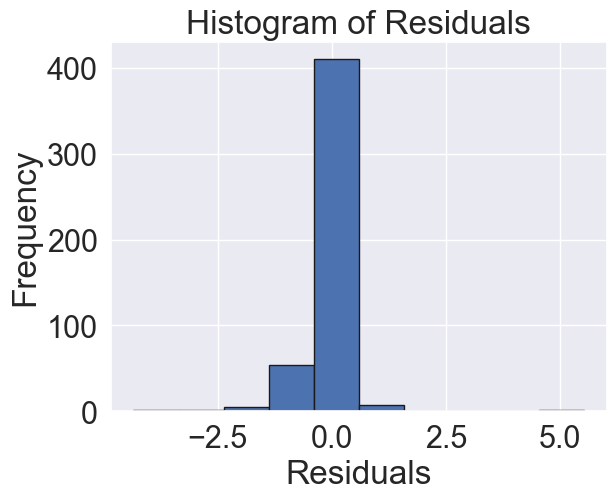

In [ ]:
# differences between actual and predicted values 
residuals = y_test - predictions

# Histogram of residuals
plt.hist(residuals, bins=10, edgecolor='k')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()


The quality of the predictions is additionally visualized in a regression plot depicting predicted values by the developed Linear Regression model versus the true CO2 emissions per capita values (DV) from the test subset:

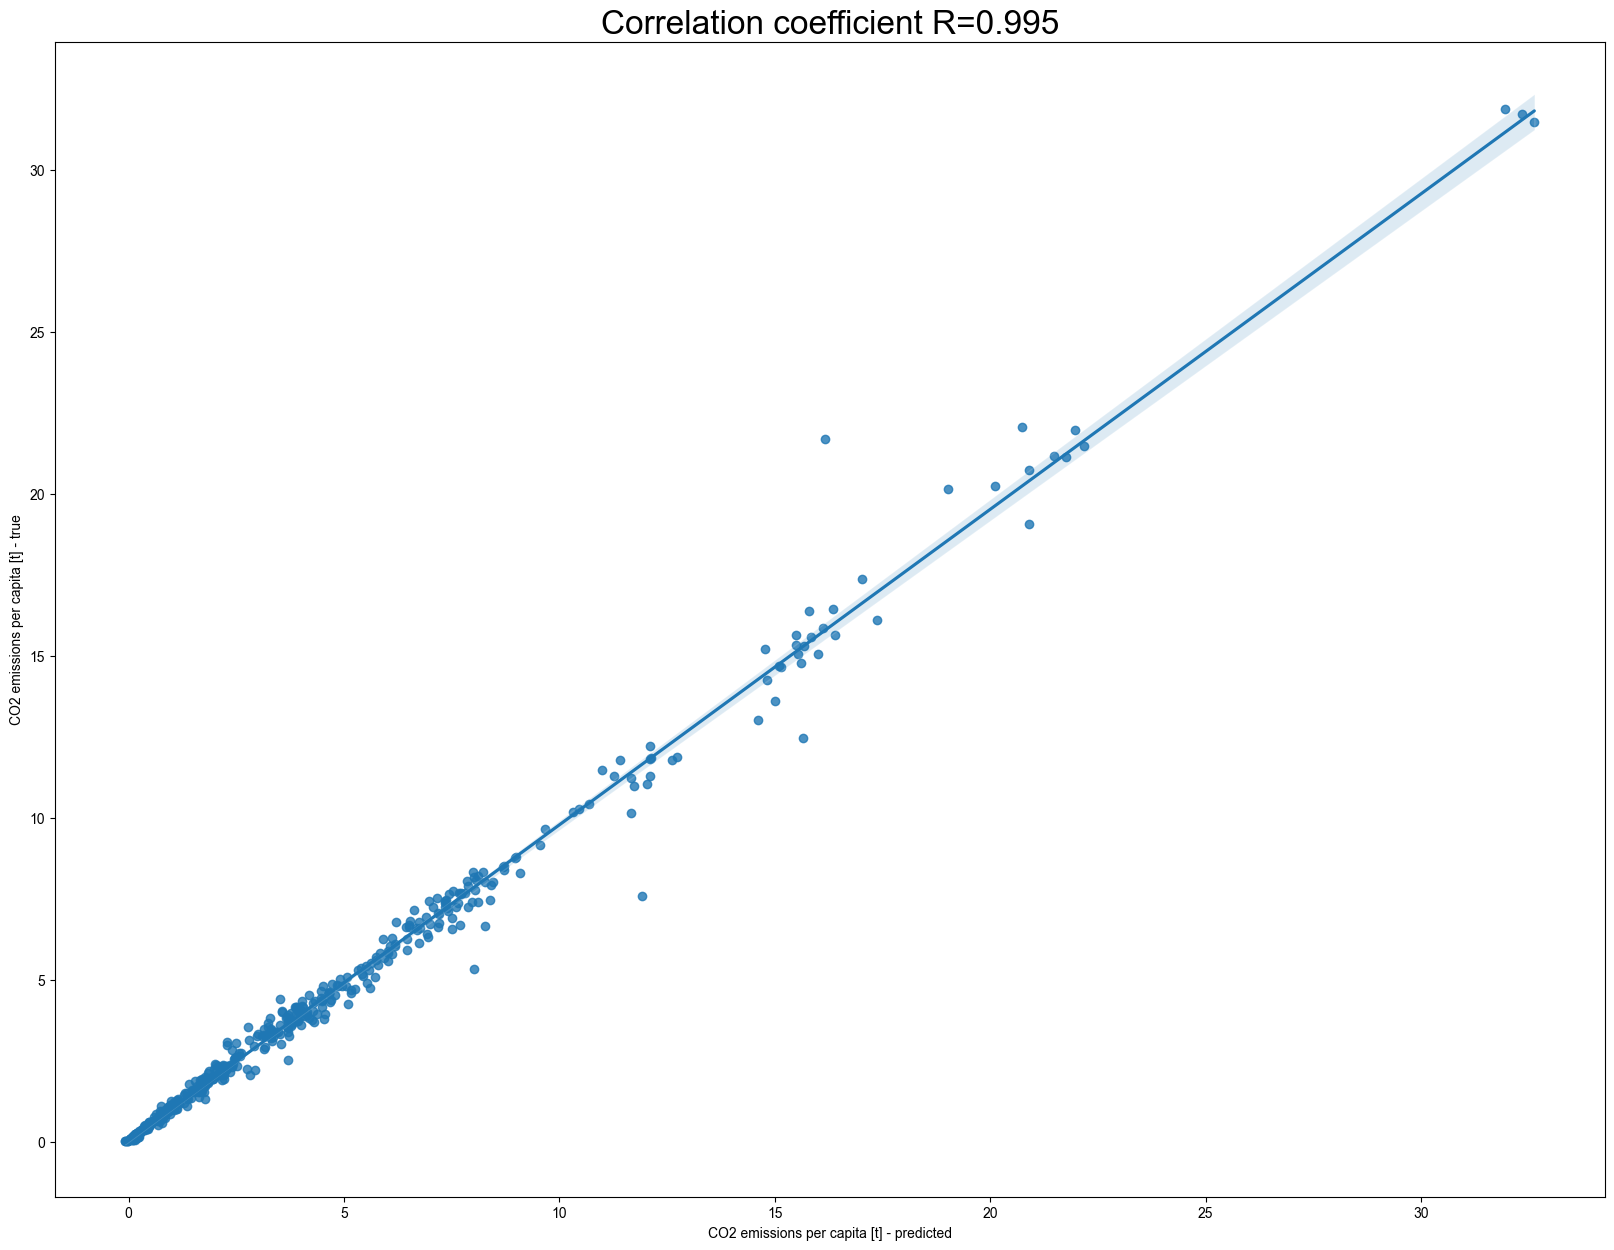

In [36]:
# Ensure y_test is a 1-dimensional array
y_test = np.array(y_test).flatten()
predictions = np.array(predictions).flatten()

# Plot predicted vs true values of the test subset
f, ax = plt.subplots(figsize=(20, 15))
sns.set(font_scale=2)

sns.regplot(x=predictions, y=y_test, fit_reg=True)
plt.xlabel("CO2 emissions per capita [t] - predicted")
plt.ylabel("CO2 emissions per capita [t] - true")

correlation_coefficient = np.corrcoef(predictions, y_test)[0, 1]
plt.title("Correlation coefficient R=" + str(round(correlation_coefficient, 3)))
plt.show()

The predictions of the CO2 emissions correlate very well with their true values and their vast majority is observed on the regression line or in its immediate vicinity.

In [37]:
# Extract the linear regression model from the pipeline
linear_model = lr_best_model.named_steps['linear']

# Create a DataFrame with the feature importances (coefficients)
feature_importances = pd.DataFrame(data=linear_model.coef_,
                                   index=features_train_reduced.columns,
                                   columns=['importance'])

# Sort the feature importances
feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False)

# Display the feature importances
print(feature_importances_sorted)

                               importance
co2_emissions_per_capita         5.367364
Qatar                            0.326506
Kuwait                           0.205902
Bahrain                          0.172840
United Arab Emirates             0.155575
...                                   ...
Albania                         -0.047435
Costa Rica                      -0.047832
year                            -0.081558
fertility_rate                  -0.129182
co2_emissions_per_capita_lag1   -0.303941

[169 rows x 1 columns]


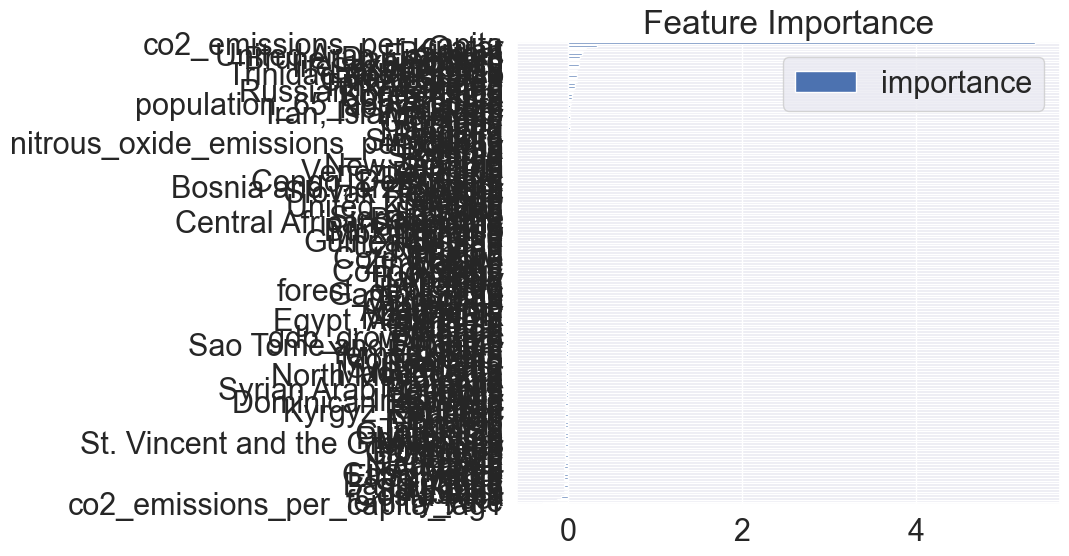

In [38]:
feature_importances.sort_values('importance').plot(kind='barh', title='Feature Importance', figsize=(7, 6))
plt.show()

In [39]:
feature_importances.sort_values('importance', ascending=False).head(100)

,importance
co2_emissions_per_capita,5.367364
Qatar,0.326506
Kuwait,0.205902
Bahrain,0.172840
United Arab Emirates,0.155575
...,...
Chile,-0.017440
Tanzania,-0.017643
Azerbaijan,-0.017951
Hungary,-0.018050


As we can see in the previos plot there are too many features to get a nice overview. Therefore we will not look at the dummy variables (countries). 

<Axes: title={'center': 'Feature Importance'}>

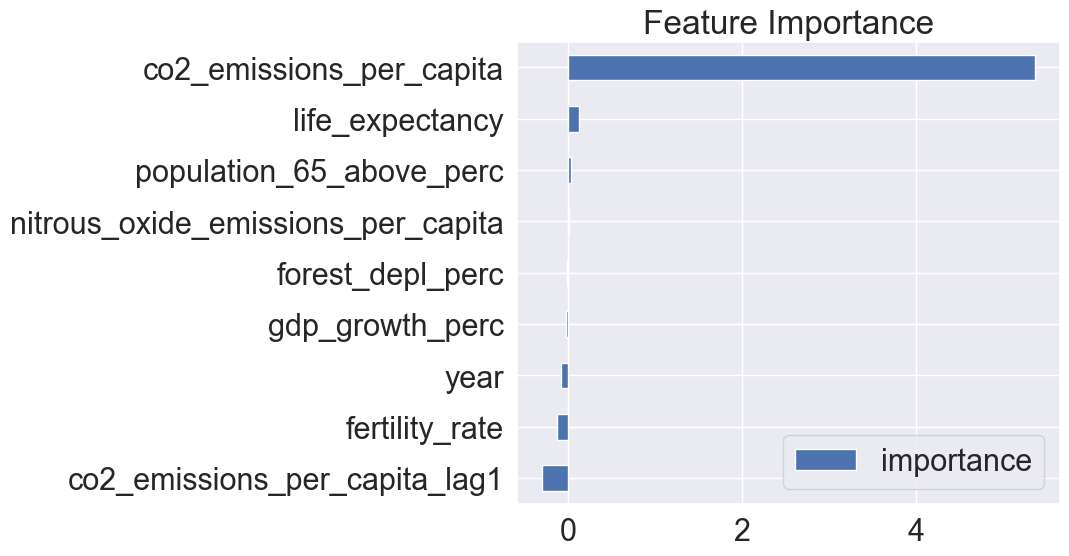

In [40]:
interesting_features = final_selected_features_df.columns

# country is not in the training DataFrame since we created dummy variables for it
interesting_features.drop('country')

# Filter the feature_importances DataFrame to include only the interesting features
filtered_feature_importances = feature_importances[feature_importances.index.isin(interesting_features)]

# Sort by importance
filtered_feature_importances_sorted = filtered_feature_importances.sort_values('importance')

# Plot the feature importances
filtered_feature_importances_sorted.plot(kind='barh', y='importance', title='Feature Importance', figsize=(7, 6))

## conclusion
As expected the co2 emissions of the current year is the most important feature but the other features do not seem to have a high influence.




